## Project Background

When providing insurance, there are very few points of contact between customers and the insurance provider.Because of this, AutoInland(an insurance company in West Africa with a focus in Auto Insurance) needs to make every point of contact count; one of the most valuable of these is filing and settlement of claims.

AutoInland believes that to achieve better service level standards, they need to anticipate future demands in terms of claims request volume. This will allow them to better manage their resources while keeping the customer experience positive and the levels of satisfaction high.

#### Objective
Thr objective of this hackathon is to develop a predictive model that determines if a customer will submit a vehicle insurance claim in the next three months. This solution will help streamline financial planning at AutoInland and allow them ti=o beter serve their customers by understanding which customers are likely to submit a claim.

In [352]:
import pandas as pd
import numpy as np

# import visualization libraries
import matplotlib.pyplot as plt
import matplotlib as pyplot
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [353]:
# reading data
train_df = pd.read_csv('./Train.csv')
test_df = pd.read_csv('./Test.csv')
submission_df = pd.read_csv('./SampleSubmission.csv')

In [354]:
print('Train data has the shape' + str(train_df.shape))
print('-----------------------------------')
print('Test data has the shape' + str(test_df.shape))

Train data has the shape(12079, 14)
-----------------------------------
Test data has the shape(1202, 13)


In [355]:
train_df.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [356]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      12079 non-null  object
 1   Policy Start Date       12079 non-null  object
 2   Policy End Date         12079 non-null  object
 3   Gender                  11720 non-null  object
 4   Age                     12079 non-null  int64 
 5   First Transaction Date  12079 non-null  object
 6   No_Pol                  12079 non-null  int64 
 7   Car_Category            8341 non-null   object
 8   Subject_Car_Colour      5117 non-null   object
 9   Subject_Car_Make        9603 non-null   object
 10  LGA_Name                5603 non-null   object
 11  State                   5591 non-null   object
 12  ProductName             12079 non-null  object
 13  target                  12079 non-null  int64 
dtypes: int64(3), object(11)
memory usage: 1.3+ MB


In [357]:
# create a copy of the dataframe to work it
#train = train_df.copy()
#test = test_df.copy()
target_df = train_df['target']

In [358]:
train_df.isna().sum()

ID                           0
Policy Start Date            0
Policy End Date              0
Gender                     359
Age                          0
First Transaction Date       0
No_Pol                       0
Car_Category              3738
Subject_Car_Colour        6962
Subject_Car_Make          2476
LGA_Name                  6476
State                     6488
ProductName                  0
target                       0
dtype: int64

In [359]:
# Filtering out the categorical and continous variables to explore and see
# what are data looks like 

# select categorical train variables
cat_train_data = train_df.select_dtypes(include=['object'])
# Selecting our continous train variable for preprocessing
con_train_data = train_df.select_dtypes(exclude=['object'])

# create a function to fill nan for categorical columns
def fillna(col):
    col.fillna(col.value_counts().index[0],inplace=True)
    return col

In [360]:
# apply function to fill nan to categorical variables
cat_train_data = cat_train_data.apply(lambda col:fillna(col))

In [361]:
# create function to plot continous data distribution
def plot_con_distribution(dataframe):
    fig, axes = plt.subplots(1,2, figsize=(14, 6))
    sns.histplot(dataframe, x='No_Pol', label ='histogram', multiple='dodge', hue='target',
               shrink=.8, binwidth=10, ax=axes[0])
    sns.boxplot(x=dataframe['target'], y=dataframe['Age'], ax=axes[1])
    axes[0].set_xlim(0, 200)
    axes[1].set_yscale('log')
    axes[0].set_title('Histogram Distribution by No_Pol', fontsize=14)
    axes[1].set_title('Distribution by Age', fontsize=14)
    plt.show()   

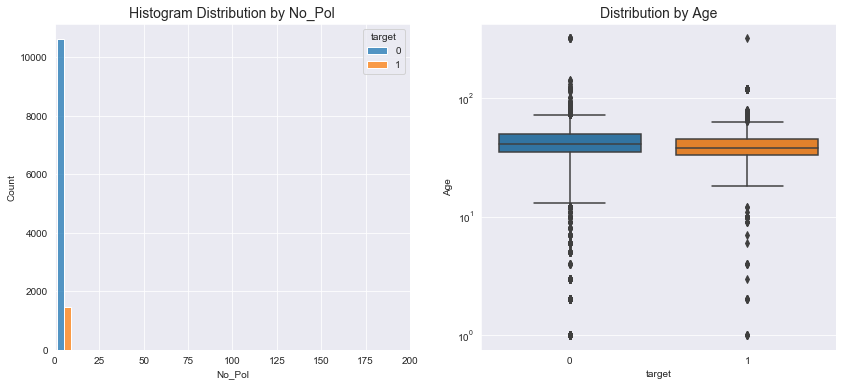

In [362]:
# apply plot_con_distribution function to con_train_data
plot_con_distribution(con_train_data)

We see the data is skewed with some outliers. We will have to make a decision as whether to remove or keep them based on how well the model is performing

In [363]:
con_train_data['target'].value_counts()

0    10624
1     1455
Name: target, dtype: int64

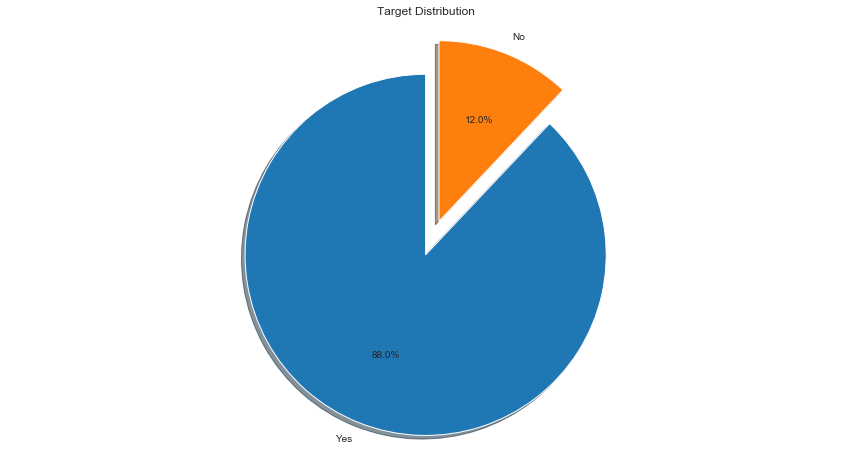

In [364]:
# lets also look at the distribution of the target variable
labels = 'Yes', 'No'
sizes = [con_train_data.target[con_train_data['target']== 0].count(), con_train_data.target[con_train_data['target']== 1].count()]
explode = (0, 0.2)
fig1, ax1 = plt.subplots(figsize=(15,8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow = True, startangle=90)
ax1.axis('equal')
plt.title('Target Distribution')
plt.show()


The target distribution is severely skewed in thge minority class looking at the above chart

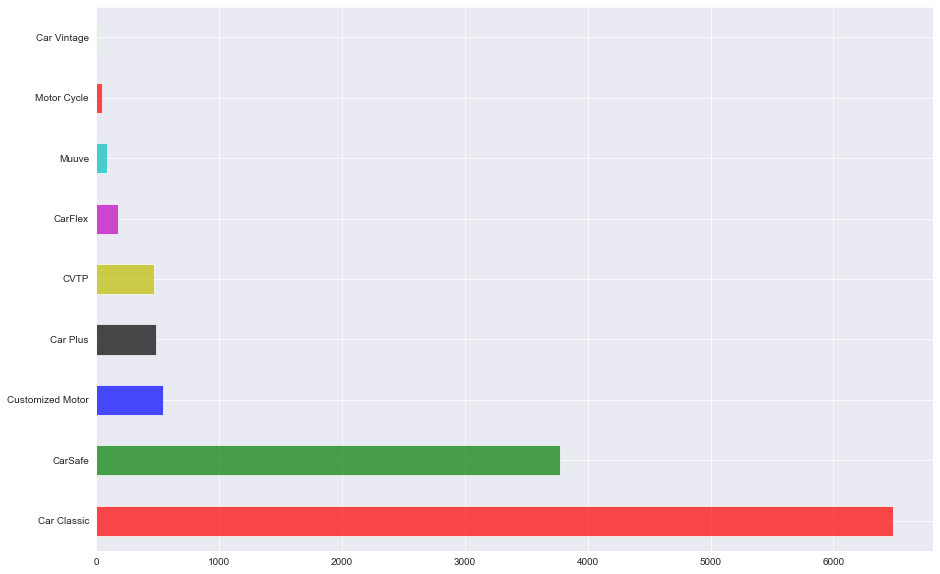

In [365]:
# Explore more categorical variables
cat_train_data['ProductName'].value_counts().plot(kind='barh',
                                                        color=list('rgbkymc'),
                                                            alpha=0.7,figsize=(15,10))
plt.show()

### Feature Engineering

In [366]:
# dropping the target to merge train and test data for feature engineering and bulding model
#train.drop('target', axis = 1, inplace = True)
# Change each column to its appriopriate datatype


# Confirm whether the changes have been applied successfully


# merge train and test data
#frames = [train, test]
df = pd.concat((train_df, test_df)).reset_index(drop=True)
#df = pd.concat(frames)

In [367]:
df.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0.0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1.0
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0.0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0.0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1.0


In [368]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      13281 non-null  object 
 1   Policy Start Date       13281 non-null  object 
 2   Policy End Date         13281 non-null  object 
 3   Gender                  12881 non-null  object 
 4   Age                     13281 non-null  int64  
 5   First Transaction Date  13281 non-null  object 
 6   No_Pol                  13281 non-null  int64  
 7   Car_Category            9171 non-null   object 
 8   Subject_Car_Colour      5622 non-null   object 
 9   Subject_Car_Make        10557 non-null  object 
 10  LGA_Name                6149 non-null   object 
 11  State                   6137 non-null   object 
 12  ProductName             13281 non-null  object 
 13  target                  12079 non-null  float64
dtypes: float64(1), int64(2), object(11)
me

In [369]:
# set each column to its apppproriate data type
date_cols = [col for col in df.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in df.columns if col not in date_cols+num_cols+['ID', 'target']]

for col in df.columns:
  if col in date_cols:
    df[col] = pd.to_datetime(df[col])
  elif col in cat_cols:
    df[col] = df[col].astype('category')
    
# Confirm whether the changes have been applied successfully
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      13281 non-null  object        
 1   Policy Start Date       13281 non-null  datetime64[ns]
 2   Policy End Date         13281 non-null  datetime64[ns]
 3   Gender                  12881 non-null  category      
 4   Age                     13281 non-null  int64         
 5   First Transaction Date  13281 non-null  datetime64[ns]
 6   No_Pol                  13281 non-null  int64         
 7   Car_Category            9171 non-null   category      
 8   Subject_Car_Colour      5622 non-null   category      
 9   Subject_Car_Make        10557 non-null  category      
 10  LGA_Name                6149 non-null   category      
 11  State                   6137 non-null   category      
 12  ProductName             13281 non-null  catego

In [370]:
# fill missing values
df = df.apply(lambda col:fillna(col))

In [371]:
# convert policy start date and end date to datetime
#df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
#df['Policy End Date'] = pd.to_datetime(df['Policy End Date'])
#df['Policy Start Date'].dtype

lets also assume that there could be a trend between policy start date and policy end date by considering client's fast response to insurance schemes. 
We will create new feature called Elasped time - this is to picture the time difference between the start of the policy and end of the policy prior to client's response. 
We also look to extract other datetime features like year of policy, month of policy and day of policy. One more thing to look at is the First Day of Transaction field which
is the duplicate of Policy Start Date, which will be of no use to us.

In [372]:
# create new column called Elasped time
df['Elapsed_Time'] = df['Policy End Date'] - df['Policy Start Date']

# Extract month columns for the policy start date and policy end date to try model improvement
df['Policy_Start_Month'] = pd.DatetimeIndex(df['Policy Start Date']).month
df['Policy_End_Month'] = pd.DatetimeIndex(df['Policy End Date']).month

# Extract year columns for the policy start date and policy end date
df['Policy_Start_Year'] = pd.DatetimeIndex(df['Policy Start Date']).year
df['Policy_End_Year'] = pd.DatetimeIndex(df['Policy End Date']).year

# Extract weekday for policy start state date and poicy end date
df['Weekday_Start_Policy'] = pd.DatetimeIndex(df['Policy Start Date']).weekday
df['Weekday_End_Policy'] = pd.DatetimeIndex(df['Policy End Date']).weekday

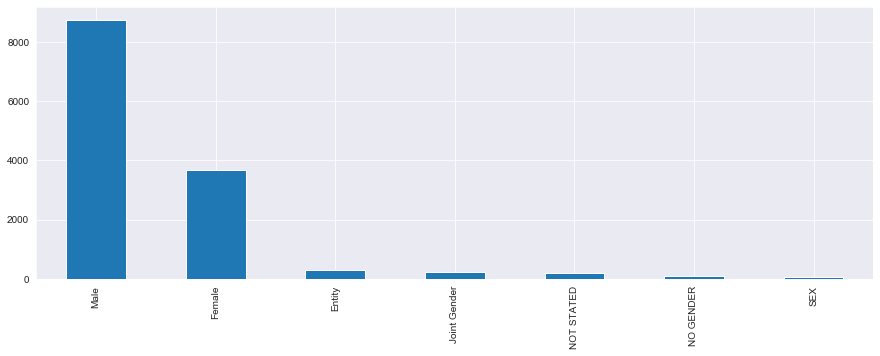

In [373]:
# view distribution of Gender
df['Gender'].value_counts().plot(kind='bar', figsize=[15,5])

In [374]:
# use map function
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
df.Gender = df.Gender.replace(mapper)

# Confirm mappings
df.Gender.value_counts()

Male      8756
Female    3679
Other      846
Name: Gender, dtype: int64

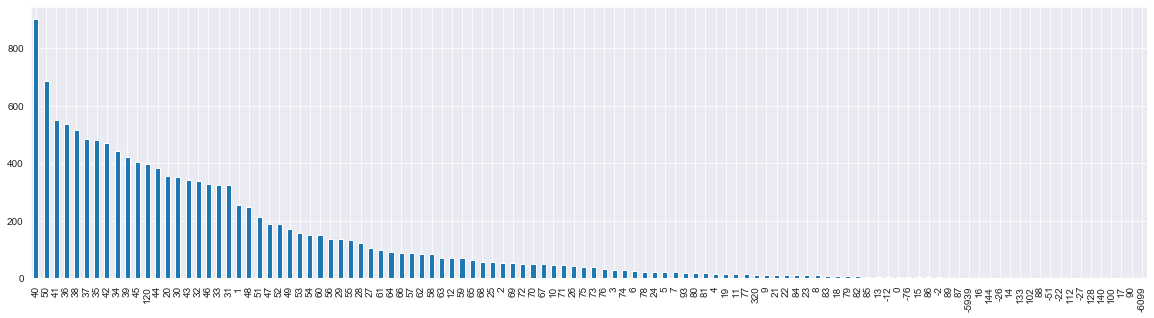

In [375]:
# feature enginerring for the continous variables
# view distribution of Age variable
df['Age'].value_counts().plot(kind='bar', figsize=[20,5])

In [376]:
# adding a list of condition
conditions = [
    (df['Age'] <= 40),
    (df['Age'] > 50)
 & (df['Age'] <= 60),
    (df['Age'] > 60)
 & (df['Age'] <= 100),
    (df['Age'] > 100)
]

# Create a list of values to assign condition
values = ['1', '4', '3', '2']

# create new datafame with condition
df['Age_band'] = np.select(conditions, values)

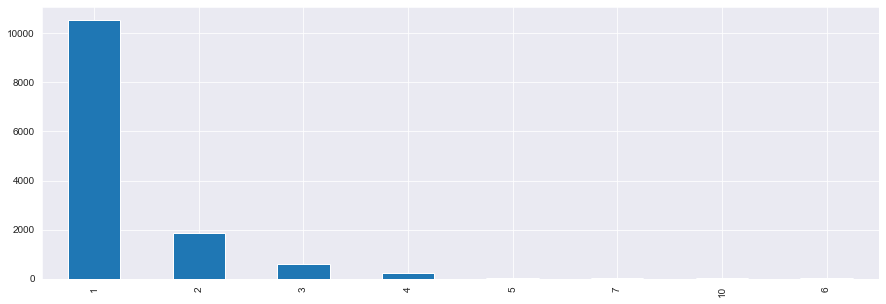

In [377]:
# view distribution of No_Pol
df['No_Pol'].value_counts().plot(kind='bar', figsize=[15,5])

In [378]:
# add a list of condition
conditions = [
    (df['No_Pol'] == 1),
    (df['No_Pol'] == 2),
    (df['No_Pol'] == 3),
    (df['No_Pol'] == 4)
]

# create a list of values to asign condition
values = ['2','5', '7', '8']

# create new dataframe with a new column
df['Pols'] = np.select(conditions, values)

In [379]:
df.head(2)

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,...,target,Elapsed_Time,Policy_Start_Month,Policy_End_Month,Policy_Start_Year,Policy_End_Year,Weekday_Start_Policy,Weekday_End_Policy,Age_band,Pols
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,...,0.0,364 days,5,5,2010,2011,4,4,1,2
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,...,1.0,364 days,11,11,2010,2011,0,0,3,2


### Preparing Data for Modeling

In [380]:
from sklearn.preprocessing import LabelEncoder
import warnings 
warnings.filterwarnings('ignore')

In [381]:
# drop the irrelevant columns
df.drop(columns=['ID', 'Policy Start Date','Age', 'No_Pol','target', 'Policy End Date', 'First Transaction Date'], axis=1, inplace=True)

# split dsta for preprocessing
train_df = df.iloc[: 12079, : ]
test_df = df.iloc[12079:, :]

In [382]:
train_df.head()

,Gender,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,Elapsed_Time,Policy_Start_Month,Policy_End_Month,Policy_Start_Year,Policy_End_Year,Weekday_Start_Policy,Weekday_End_Policy,Age_band,Pols
0,Male,Saloon,Black,TOYOTA,Victoria Island,Lagos,Car Classic,364 days,5,5,2010,2011,4,4,1,2
1,Female,JEEP,Grey,TOYOTA,Victoria Island,Lagos,Car Classic,364 days,11,11,2010,2011,0,0,3,2
2,Male,Saloon,Red,TOYOTA,Victoria Island,Lagos,Car Classic,364 days,3,3,2010,2011,6,6,0,2
3,Male,Saloon,Black,TOYOTA,Victoria Island,Lagos,CarSafe,364 days,8,8,2010,2011,5,5,1,2
4,Other,Saloon,Black,TOYOTA,Lagos,Lagos,Muuve,124 days,8,12,2010,2010,6,4,1,7


In [383]:
# encode categorical train data
train_df['Gender'] = LabelEncoder().fit_transform(train_df.Gender)
train_df['Car_Category'] = LabelEncoder().fit_transform(train_df.Car_Category)
train_df['Subject_Car_Colour'] = LabelEncoder().fit_transform(train_df.Subject_Car_Colour)
train_df['Subject_Car_Make'] = LabelEncoder().fit_transform(train_df.Subject_Car_Make)
train_df['LGA_Name'] = LabelEncoder().fit_transform(train_df.LGA_Name)
train_df['State'] = LabelEncoder().fit_transform(train_df.State)
train_df['ProductName'] = LabelEncoder().fit_transform(train_df.ProductName)
train_df['Elapsed_Time'] = LabelEncoder().fit_transform(train_df.Elapsed_Time).astype(int)

In [384]:
# encode categorical test data
test_df['Gender'] = LabelEncoder().fit_transform(test_df.Gender)
test_df['Car_Category'] = LabelEncoder().fit_transform(test_df.Car_Category)
test_df['Subject_Car_Colour'] = LabelEncoder().fit_transform(test_df.Subject_Car_Colour)
test_df['Subject_Car_Make'] = LabelEncoder().fit_transform(test_df.Subject_Car_Make)
test_df['LGA_Name'] = LabelEncoder().fit_transform(test_df.LGA_Name)
test_df['State'] = LabelEncoder().fit_transform(test_df.State)
test_df['ProductName'] = LabelEncoder().fit_transform(test_df.ProductName)
test_df['Elapsed_Time'] = LabelEncoder().fit_transform(test_df.Elapsed_Time).astype(int)

In [385]:
train_df.shape, test_df.shape

((12079, 16), (1202, 16))

In [386]:
#train_df.drop('target', axis=1, inplace=True)
#test_df.drop('target', axis=1, inplace=True)

In [387]:
train_df.head(5)

,Gender,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,Elapsed_Time,Policy_Start_Month,Policy_End_Month,Policy_Start_Year,Policy_End_Year,Weekday_Start_Policy,Weekday_End_Policy,Age_band,Pols
0,1,8,4,67,247,73,1,276,5,5,2010,2011,4,4,1,2
1,0,2,26,67,247,73,1,276,11,11,2010,2011,0,0,3,2
2,1,8,32,67,247,73,1,276,3,3,2010,2011,6,6,0,2
3,1,8,4,67,247,73,5,276,8,8,2010,2011,5,5,1,2
4,2,8,4,67,157,73,8,57,8,12,2010,2010,6,4,1,7


In [388]:
test_df.head(5)

,Gender,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,Elapsed_Time,Policy_Start_Month,Policy_End_Month,Policy_Start_Year,Policy_End_Year,Weekday_Start_Policy,Weekday_End_Policy,Age_band,Pols
12079,0,6,3,9,9,3,1,103,10,10,2010,2011,5,5,0,2
12080,1,6,3,34,69,7,1,103,10,10,2010,2011,3,3,1,2
12081,0,6,3,11,112,2,1,103,8,8,2010,2011,6,6,0,5
12082,0,6,3,34,109,29,4,103,6,6,2010,2011,6,6,4,2
12083,1,6,12,12,109,29,1,103,7,6,2010,2011,3,3,2,2


In [389]:
target_df.head()

0    0
1    1
2    0
3    0
4    1
Name: target, dtype: int64

##### Normalize the dataset

In [390]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# fit scaler on our train and test set
X_train_sc = sc.fit_transform(train_df) 
X_test_sc = sc.transform(test_df)

#### Model Building

In [391]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import StackingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
import xgboost as xgb

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [392]:
# let define our models
level10 = list()
level10.append(('lr', LogisticRegression()))
level10.append(('rf',  RandomForestClassifier()))
level10.append(('knn',  KNeighborsClassifier()))
level10.append(('svm', LinearSVC()))
level10.append(('xgb', xgb.XGBClassifier()))
level10.append(('dt',  DecisionTreeClassifier()))
# define meta learner model
level1 = LogisticRegression()
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define stacking ensamble 
model = StackingClassifier(estimators=level10, final_estimator=level1)

Recall our target distribution is heavily skewed, so we we look for a way to reduce bias by applying random sampling. In this case we will be combining both undersampling and oversampling to see if we can achieve an interesting result, by oversampling the minority class to improve bias towards data points, whilst also applying a modest amount of undersampling to the majority class.

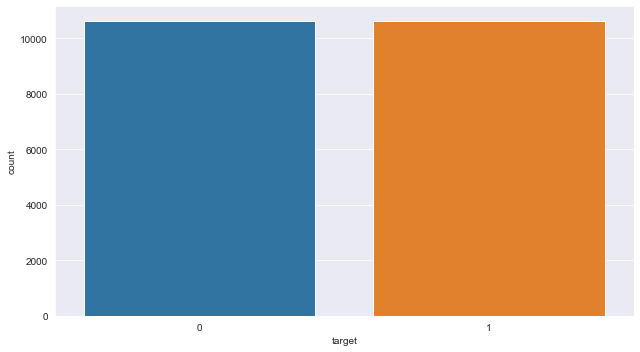

In [393]:
# apply over sample to train data
over = RandomOverSampler()
X_train_sc, target_df = over.fit_resample(X_train_sc, target_df)

fig, ax = plt.subplots(figsize=(9, 5))
sns.countplot(target_df)

plt.tight_layout()
plt.show()

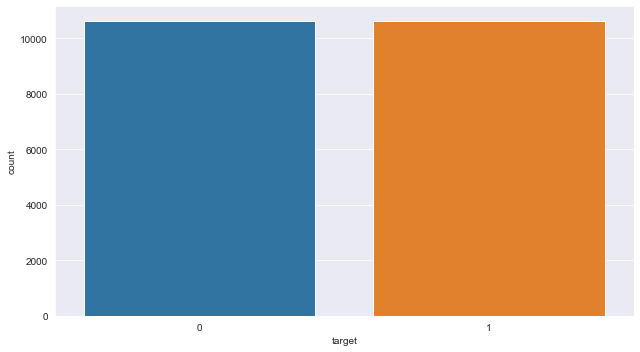

In [394]:
# apply under sample to test data
under = RandomUnderSampler(sampling_strategy=0.5)

X_train_sc, target_df = under.fit_resample(X_train_sc, target_df)

fig, ax = plt.subplots(figsize=(9, 5))
sns.countplot(target_df)

plt.tight_layout()
plt.show()

In [396]:
# define pipeline steps

over = RandomOverSampler()
under = RandomUnderSampler()
steps = [('o', over), ('u', under), ('m', model)]
pipeline = Pipeline(steps=steps)

In [397]:
# fit pipeline model
pipeline.fit(X_train_sc, target_df)

Pipeline(steps=[('o', RandomOverSampler()), ('u', RandomUnderSampler()),
                ('m',
                 StackingClassifier(estimators=[('lr', LogisticRegression()),
                                                ('rf',
                                                 RandomForestClassifier()),
                                                ('knn', KNeighborsClassifier()),
                                                ('svm', LinearSVC()),
                                                ('xgb', XGBClassifier()),
                                                ('dt',
                                                 DecisionTreeClassifier())],
                                    final_estimator=LogisticRegression()))])

In [398]:
predictions = pipeline.predict(X_test_sc)

##### Load submission file

In [401]:
# create submission file
sub_file = submission_df.copy()
sub_file.target = predictions

# check distribution of prediction
#sns.countplot(sub_file.predictions)

In [402]:
sub_file.to_csv('Model1.csv', index = False)

In [75]:
# create new submission file dataframe to hold our predicted values
submissionFile= pd.DataFrame({'ID':test_df['ID']})
submissionFile['target'] = y_pred

In [76]:
# save submission file to csv
submissionFile.to_csv('my_model2.csv', index=False)